Scikit-learn HistGradientBoostingRegressor() model on MDA_dataframeArthur.csv.

Time Series cross-validation: 24h delay for weather, 1 month gap between train and test sets.
MAE en RMSE can be compared to other models.

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

Dataframe is loaded, 24h-delayed noise is added. Datetime column is dropped in order to run model.

In [7]:
df = pd.read_csv("C:\\Users\Arthur\hello\MDA_dataframeArthur.csv")
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'],format='%Y-%m-%d %H:%M:%S')
df_noisedelay = df[['result_timestamp','laeq']]
df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']
df_noisedelay = df_noisedelay.drop('laeq', axis=1)
df = pd.merge(df,df_noisedelay, on='result_timestamp',validate='1:1')
df_nd = df.drop('result_timestamp', axis=1)
df_nd[df_nd['month']==1]

C:\Users\Arthur\AppData\Local\Temp\ipykernel_9872\1140074603.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['result_timestamp'] = df_noisedelay['result_timestamp']+pd.DateOffset(days=1)
C:\Users\Arthur\AppData\Local\Temp\ipykernel_9872\1140074603.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noisedelay['laeq_delayed'] = df_noisedelay['laeq']


,laeq,hour,day,day_of_month,month,weekend,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3,laeq_delayed
0,39.220000,0,0,3,1,0,80.0,9.05,38.0,0.0,0.0,0.0,-23.0,0.09,0.0,12.33,12.33,12.273,12.356070,40.954667
1,39.086333,0,0,3,1,0,80.0,9.11,37.0,0.0,0.0,0.0,-7.0,0.05,0.0,12.39,12.39,12.333,12.349950,37.623667
2,35.598000,0,0,3,1,0,79.0,8.99,38.0,0.0,0.0,0.0,-32.0,0.17,0.0,12.42,12.42,12.363,12.334590,36.445333
3,37.734500,0,0,3,1,0,79.0,9.01,37.0,0.0,0.0,0.0,29.0,0.03,0.0,12.51,12.51,12.453,12.353540,38.298000
4,38.009167,0,0,3,1,0,79.0,9.14,38.0,0.0,0.0,0.0,-66.0,0.03,0.0,12.61,12.61,12.553,12.443330,39.350417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3989,49.306167,23,0,31,1,0,79.0,2.23,39.0,0.0,0.0,0.0,15.0,0.18,0.0,5.52,5.52,5.463,5.523212,43.836938
3990,44.894667,23,0,31,1,0,79.0,2.28,37.0,0.0,0.0,0.0,-29.0,0.18,0.0,5.61,5.61,5.553,5.615173,44.604500
3991,42.108833,23,0,31,1,0,79.0,2.31,38.0,0.0,0.0,0.0,-47.0,0.27,0.0,5.61,5.61,5.553,5.591562,41.070618
3992,44.966833,23,0,31,1,0,80.0,2.27,37.0,0.0,0.0,0.0,-17.0,0.13,0.0,5.49,5.49,5.433,5.495993,43.624667


The target dataset (y) and predictor dataset (X) are created.

In [8]:
y = df_nd["laeq"]
X = df_nd.drop("laeq", axis="columns")

In [9]:
#create time-sensitive split for cross-validation
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=4320,
    max_train_size=10000,
    test_size=1000,
)

In [10]:
#inspect splits
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]
X.iloc[test_0]
X.iloc[train_0]

,hour,day,day_of_month,month,weekend,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3,laeq_delayed
32664,8,4,19,8,0,81.0,16.86,31.0,142.0,0.0,0.0,-151.0,0.01,90.0,20.12,20.12,20.063,19.755652,57.680667
32665,8,4,19,8,0,78.0,16.51,32.0,154.0,0.0,0.0,93.0,0.09,110.0,20.41,20.41,20.353,19.684666,54.468667
32666,8,4,19,8,0,76.0,16.41,32.0,166.0,0.0,0.0,102.0,0.19,124.0,20.70,20.70,20.643,19.820948,57.212833
32667,8,4,19,8,0,77.0,16.80,31.0,147.0,0.0,0.0,100.0,0.32,135.0,20.92,20.92,20.863,20.122028,66.073667
32668,8,4,19,8,0,77.0,16.82,32.0,118.0,0.0,0.0,86.0,0.15,145.0,21.06,21.06,21.003,20.303389,57.575333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42659,22,3,27,10,0,89.0,13.82,38.0,0.0,0.0,0.0,-85.0,0.00,0.0,15.72,15.72,15.663,15.484560,54.600667
42660,22,3,27,10,0,88.0,13.72,37.0,0.0,0.0,0.0,0.0,0.00,0.0,15.72,15.72,15.663,15.532880,55.474667
42661,22,3,27,10,0,88.0,13.77,38.0,0.0,0.0,0.0,0.0,0.00,0.0,15.72,15.72,15.663,15.517010,55.692000
42662,23,3,27,10,0,89.0,13.83,37.0,0.0,0.0,0.0,92.0,0.00,0.0,15.67,15.67,15.613,15.470730,56.306833


In [11]:
train_4, test_4 = all_splits[4]
X.iloc[test_4]
X.iloc[train_4]

,hour,day,day_of_month,month,weekend,LC_HUMIDITY,LC_DWPTEMP,LC_n,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3,laeq_delayed
36664,3,4,16,9,0,96.0,11.80,32.0,0.0,0.0,0.000,0.0,0.00,0.0,12.41,12.41,12.353,12.370788,35.134667
36665,3,4,16,9,0,96.0,11.89,31.0,0.0,0.0,0.000,0.0,0.00,0.0,12.50,12.50,12.443,12.419055,37.770833
36666,3,4,16,9,0,96.0,11.91,32.0,0.0,0.0,0.000,0.0,0.00,0.0,12.56,12.56,12.503,12.463383,34.552022
36667,3,4,16,9,0,95.0,11.78,31.0,0.0,0.0,0.000,0.0,0.00,0.0,12.61,12.61,12.553,12.584451,35.127880
36668,4,4,16,9,0,95.0,11.78,32.0,0.0,0.0,0.000,0.0,0.00,0.0,12.61,12.61,12.553,12.625539,33.914667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46659,22,3,24,11,0,89.0,7.11,38.0,0.0,0.0,0.008,-29.0,0.02,0.0,8.78,8.78,8.723,8.760870,59.341500
46660,22,3,24,11,0,89.0,7.17,36.0,0.0,0.0,0.008,-89.0,0.04,0.0,8.86,8.86,8.803,8.826091,57.818333
46661,22,3,24,11,0,87.0,6.96,38.0,0.0,0.0,0.008,40.0,0.08,0.0,8.92,8.92,8.863,8.891355,58.574833
46662,22,3,24,11,0,87.0,7.03,37.0,0.0,0.0,0.008,-16.0,0.10,0.0,9.00,9.00,8.943,8.983234,56.370050


In [21]:
# grid search for hyperparameter tuning
param_grid = {
    'learning_rate': (0.07,0.08,0.09,0.10),
    'max_leaf_nodes': (9,10,11,12)}
model = GradientBoostingRegressor()
model_grid_search = GridSearchCV(model, param_grid=param_grid,
                                 n_jobs=2, cv=ts_cv)
model_grid_search.fit(X, y)


GridSearchCV(cv=TimeSeriesSplit(gap=4320, max_train_size=10000, n_splits=5, test_size=1000),
             estimator=GradientBoostingRegressor(), n_jobs=2,
             param_grid={'learning_rate': (0.07, 0.08, 0.09, 0.1),
                         'max_leaf_nodes': (9, 10, 11, 12)})

In [22]:
accuracy = model_grid_search.score(X, y)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.78


In [23]:
model_grid_search.predict(X.iloc[0:5])

array([38.38260298, 36.49019698, 35.98458264, 37.04263998, 37.83887627])

In [24]:
print(f"The best set of parameters is: "
      f"{model_grid_search.best_params_}")

The best set of parameters is: {'learning_rate': 0.08, 'max_leaf_nodes': 11}


In [25]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,3.578833,0.112350,0.002591,0.000492,0.08,11,"{'learning_rate': 0.08, 'max_leaf_nodes': 11}",0.779559,0.760981,0.787090,0.712061,0.290809,0.666100,0.189457,1
7,3.597536,0.129463,0.003194,0.000746,0.08,12,"{'learning_rate': 0.08, 'max_leaf_nodes': 12}",0.777743,0.760981,0.787090,0.712080,0.290812,0.665741,0.189240,2
5,3.755701,0.157814,0.003193,0.000397,0.08,10,"{'learning_rate': 0.08, 'max_leaf_nodes': 10}",0.779032,0.760981,0.785784,0.712061,0.290809,0.665733,0.189228,3
4,4.014592,0.133025,0.002583,0.000501,0.08,9,"{'learning_rate': 0.08, 'max_leaf_nodes': 9}",0.779668,0.760981,0.781627,0.712080,0.290812,0.665034,0.188784,4
3,4.532362,0.700453,0.003796,0.000979,0.07,12,"{'learning_rate': 0.07, 'max_leaf_nodes': 12}",0.777189,0.747292,0.747202,0.709474,0.316395,0.659510,0.172898,5


In [26]:
# get the parameter names
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += [
    "mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [27]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,param_learning_rate,param_max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
6,0.08,11,0.666100,0.189457,1
7,0.08,12,0.665741,0.189240,2
5,0.08,10,0.665733,0.189228,3
4,0.08,9,0.665034,0.188784,4
3,0.07,12,0.659510,0.172898,5
1,0.07,10,0.659510,0.172898,6
2,0.07,11,0.659484,0.172880,7
0,0.07,9,0.659484,0.172880,8
10,0.09,11,0.654614,0.176041,9
9,0.09,10,0.654587,0.176022,10


In [28]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_learning_rate"],
    columns=["param_max_leaf_nodes"])

pivoted_cv_results

param_max_leaf_nodes,9,10,11,12
param_learning_rate,,,,
0.07,0.659484,0.659510,0.659484,0.659510
0.08,0.665034,0.665733,0.666100,0.665741
0.09,0.654344,0.654587,0.654614,0.653314
0.10,0.640762,0.638625,0.639472,0.640104


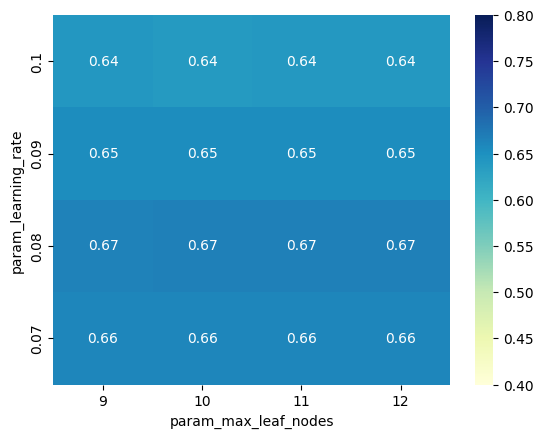

In [29]:
import seaborn as sns

ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.4,
                 vmax=0.8)
ax.invert_yaxis()

Mean Absolute Error:     2.897 +/- 0.843
Root Mean Squared Error: 3.586 +/- 0.886


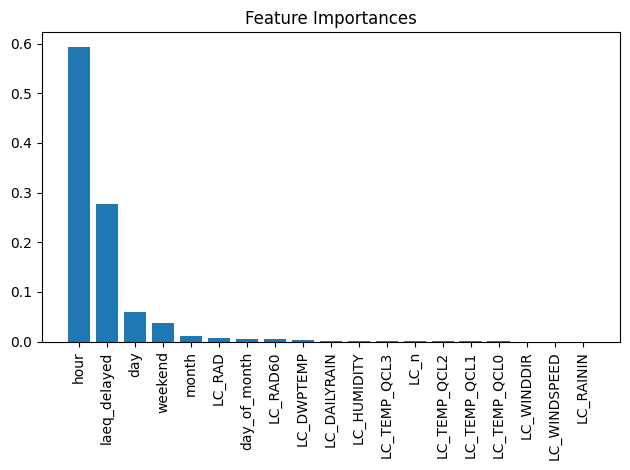

In [30]:
#run gradient boosting model and plot feature importances
import numpy as np
import matplotlib.pyplot as plt

def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

    # Fit the model on the data
    model.fit(X, y)

    # Retrieve feature importances
    feature_importances = model.named_steps['gradientboostingregressor'].feature_importances_
    feature_names = X.columns

    # Sort feature importances in descending order
    indices = np.argsort(feature_importances)[::-1]

    # Plot feature importances
    plt.figure()
    plt.title('Feature Importances')
    plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
    plt.xticks(range(X.shape[1]), feature_names[indices], rotation='vertical')
    plt.tight_layout()
    plt.show()

gbrt_pipeline = make_pipeline(GradientBoostingRegressor(max_leaf_nodes=11, learning_rate=0.08))
evaluate(gbrt_pipeline, X, y, cv=ts_cv)


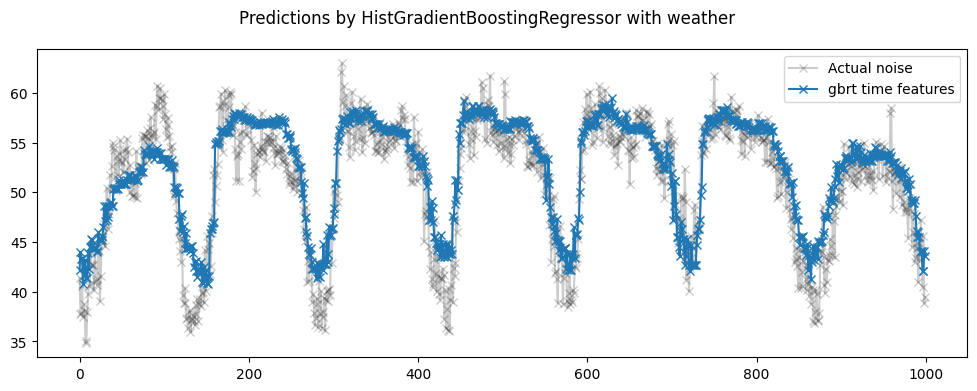

In [31]:
#Qualitative analysis of the impact of features on linear model predictions
gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_0])

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by HistGradientBoostingRegressor with weather")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(gbrt_predictions[last_hours], "x-", label="gbrt time features")
_ = ax.legend()


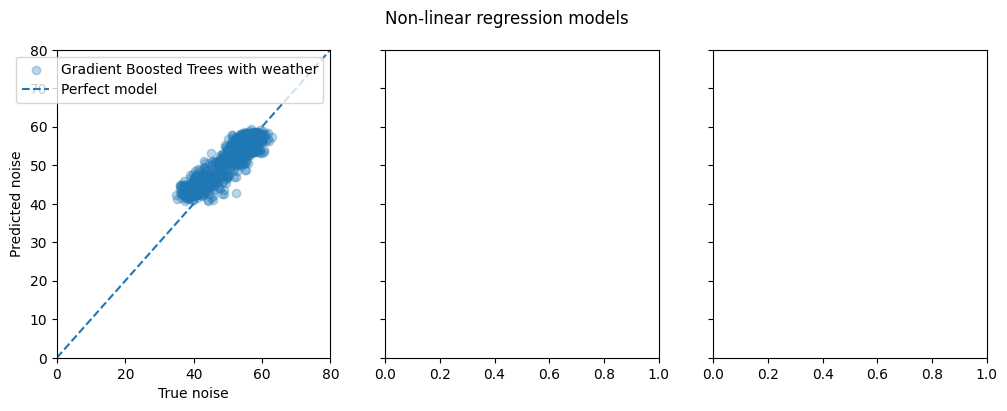

In [33]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    gbrt_predictions,
]
labels = [
    "Gradient Boosted Trees with weather",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True noise",
        ylabel="Predicted noise",
    )
    ax.legend()

plt.show()